# <center> **PROJECT. Сегментация клиентов банка.**

![Alt text](image-26.png)

## <center> **`1.` Постановка задачи**

**Цель работы:**

В нашем распоряжении есть данные о 8950 держателях кредитных карт одного из банков Нью-Йорка. Банк собрал достаточно много данных об этих людях и о том, как они пользовались кредитными картами за последние полгода.

Маркетологи хотят запустить рекламную кампанию, однако для этого необходимо произвести сегментацию клиентов, чтобы сделать акционное предложение более персонализированным.

### <center> **Организационная информация**

Проект будет состоять из пяти частей:

**`1.` Постановка задачи**;

**`2.` Исследование данных**;

**`3.` Предобработка данных**;

**`4.` Отбор и преобразование признаков**;

**`5.` Построение и сравнение моделей (Machine Learning)**.

## <center> **`2.` Исследование данных**

Импортируем необходимые библиотеки:

In [1]:
# Для работы с данными
import pandas as pd
import numpy as np

# Для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns

# Для построения модели
from sklearn import cluster
from sklearn import metrics
from sklearn import preprocessing

Прочитаем данные:

In [2]:
# Загружаем DataFrame
cc_general_data = pd.read_csv('Прочие файлы/CC GENERAL.csv')

# Создаём копию
cc_general_df = cc_general_data.copy()

In [ ]:
# Выведем первые пять строк
cc_general_df.head()

### <center> **Иформация о датасете**

Данные содержат 18 признаков и 8950 наблюдений. Из этих 18 признаков 1 — категориальный, а остальные являются непрерывными числовыми данными.

* `CUST_ID` — идентификационный номер держателя карты;
* `BALANCE` — баланс, доступный для совершения покупок;
* `BALANCEFREQUENCY` — как часто обновляется показатель баланса (1 — часто, 0 — нечасто);
* `PURCHASES` — количество покупок, оплаченных со счёта;
* `ONEOFFPURCHASES` — максимальная сумма единовременной покупки;
* `INSTALLMENTSPURCHASES` — сумма покупок, сделанных в рассрочку;
* `PURCHASESFREQUENCY` — как часто в целом совершаются покупки (1 — часто, 0 — нечасто);
* `ONEOFFPURCHASESFREQUENCY` — частота совершения единовременных покупок (1 — часто, 0 — нечасто);
* `PURCHASESINSTALLMENTSFREQUENCY` — частота совершения покупок в рассрочку (1 — часто, 0 — нечасто);
* `CASHADVANCEFREQUENCY` — частота внесения авансовых платежей;
* `CASHADVANCETRX` — количество транзакций с авансовыми взносами;
* `PURCHASESTRX` — количество совершённых транзакций с покупками;
* `CREDITLIMIT` — кредитный лимит держателя карты;
* `PAYMENTS` — сумма платежей пользователя;
* `MINIMUM_PAYMENTS` — сумма минимального платежа пользователя;
* `PRCFULLPAYMENT` — выплаченный процент от полного платежа;
* `TENURE` — срок обслуживания кредитной карты.

Посмотрим на типизацию признаков:

In [14]:
cc_general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

Проверим данные на наличие пропусков:

Суммарное количество пропусков в данных: 314 

MINIMUM_PAYMENTS    3.497207
CREDIT_LIMIT        0.011173
dtype: float64


<AxesSubplot:>

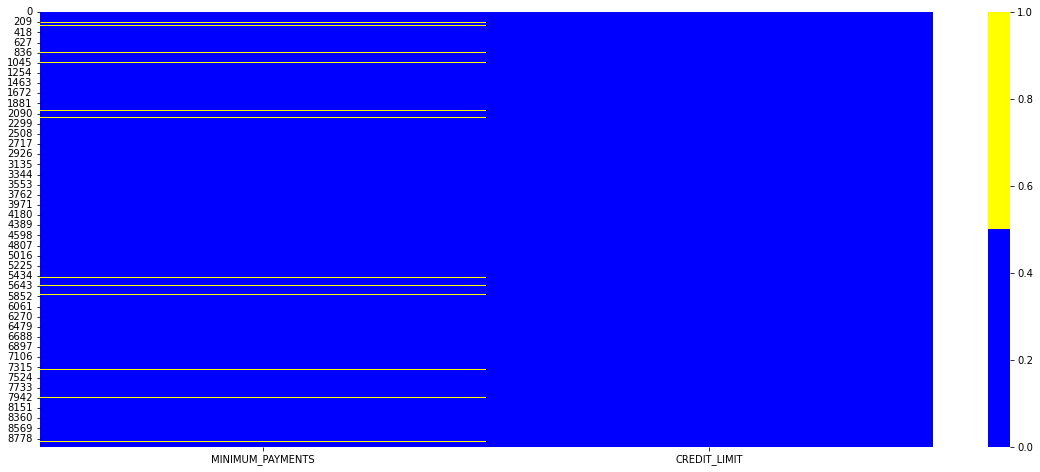

In [12]:
# Выводим суммарное количество пропусков
print('Суммарное количество пропусков в данных: {} \n'.format(cc_general_df.isnull().sum().sum()))



# Построим тепловую карту пропусков
# Создаём функцию отображения пропущенных значений на тепловой карте
def missing_values_heatmap(data):
    
    # Рассчитываем количество пропусков
    cols_null_persent = data.isnull().mean() * 100
    cols_with_null = cols_null_persent[cols_null_persent > 0].sort_values(ascending = False)
    print(cols_with_null)
    
    # Задаём параметры графика
    colors = ['blue', 'yellow']
    fig = plt.figure(figsize = (20, 8))
    cols = cols_with_null.index
    
    # Строим тепловую карту
    ax = sns.heatmap(
        data = data[cols].isnull(),
        cmap = sns.color_palette(colors)
    )
    
    return ax


# Применяем полученную функцию к нашему датасету
missing_values_heatmap(cc_general_df)

**Вывод:**

Из всех наблюдений пропуски содержат признаки `CREDIT_LIMIT` (1 пропуск) и `MINIMUM_PAYMENTS` (313 пропусков). 

## <center> **`3.` Предобработка данных** 

#### $3.1$

Пропуски обоих признаков заполним средним арифметическим значением.

In [10]:
# Создаём списки признаков для заполнения средним значением
mean_list = ['CREDIT_LIMIT', 'MINIMUM_PAYMENTS']

# Заполняем пропуски средним значением
for column in mean_list:
    cc_general_df[column] = cc_general_df[column].fillna(cc_general_df[column].mean())
    
# Выводим итоговое количество пропусков 
# и среднее арифметическое признака 'MINIMUM_PAYMENTS' округлённое до двух знаков после точки-разделителя
print(f'Количество пропусков в данных после обработки: {cc_general_df.isnull().sum().sum()}')
print('Среднее арифметическое суммы минимального платежа пользователя: {:.2f}'.format(cc_general_df.MINIMUM_PAYMENTS.mean()))

Количество пропусков в данных после обработки: 0
Среднее арифметическое суммы минимального платежа пользователя: 864.21


## <center> **`4.` Отбор и преобразование признаков**

#### $4.1$

Удаляем ненужные признаки.

In [11]:
# Удаляем признаки типа object
object_columns = [features for features in cc_general_df.columns if cc_general_df[features].dtype == 'object']
cc_general_df.drop(object_columns, axis = 1, inplace = True)

#### $4.2$

Исследуем распределение данных.

Построим график распределения признаков

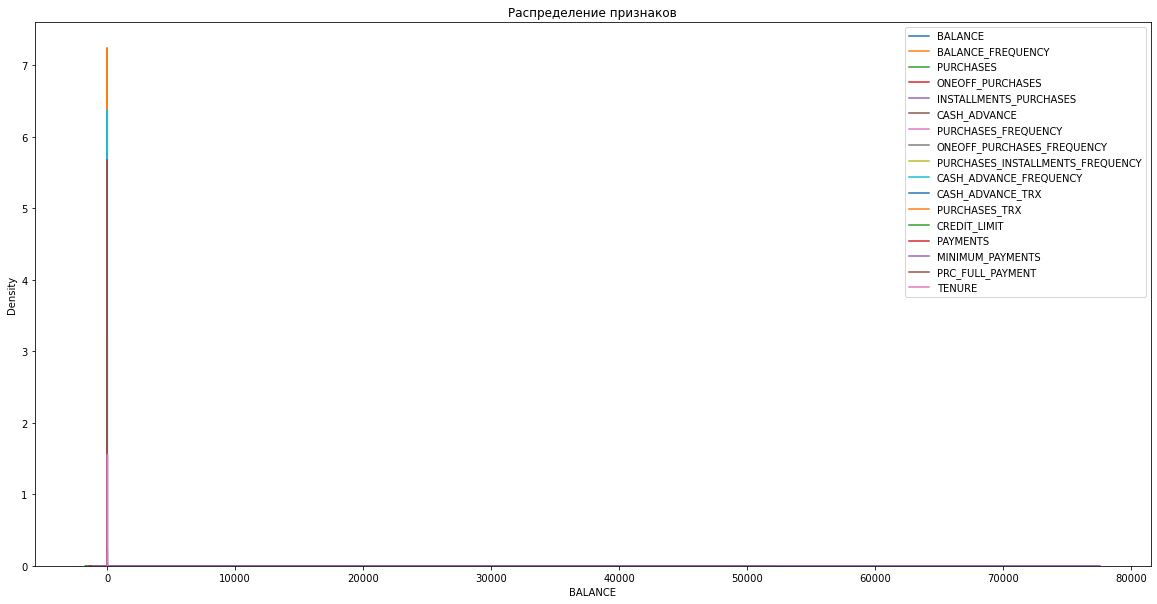

In [25]:
# Задаём параметры графика
fig, (ax) = plt.subplots(
    ncols = 1,                          # количество
    figsize = (20, 10)                  # размеры графика
)

ax.set_title('Распределение признаков') # наименование графика


# Строим график
for column in cc_general_df.columns:
    sns.kdeplot(cc_general_df[column], ax = ax, label = column)
    
# Выводим график
plt.legend()

Нормализуем данные используя `StandardScaler()`

In [12]:
# Инициализируем стандартизатор StandardScaler
ss_scaler = preprocessing.StandardScaler()

# Кодируем исходный датасет
cc_general_df_ss = ss_scaler.fit_transform(cc_general_df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
cc_general_df_ss = pd.DataFrame(cc_general_df_ss, columns = list(cc_general_df.columns))

Визуализируем данные

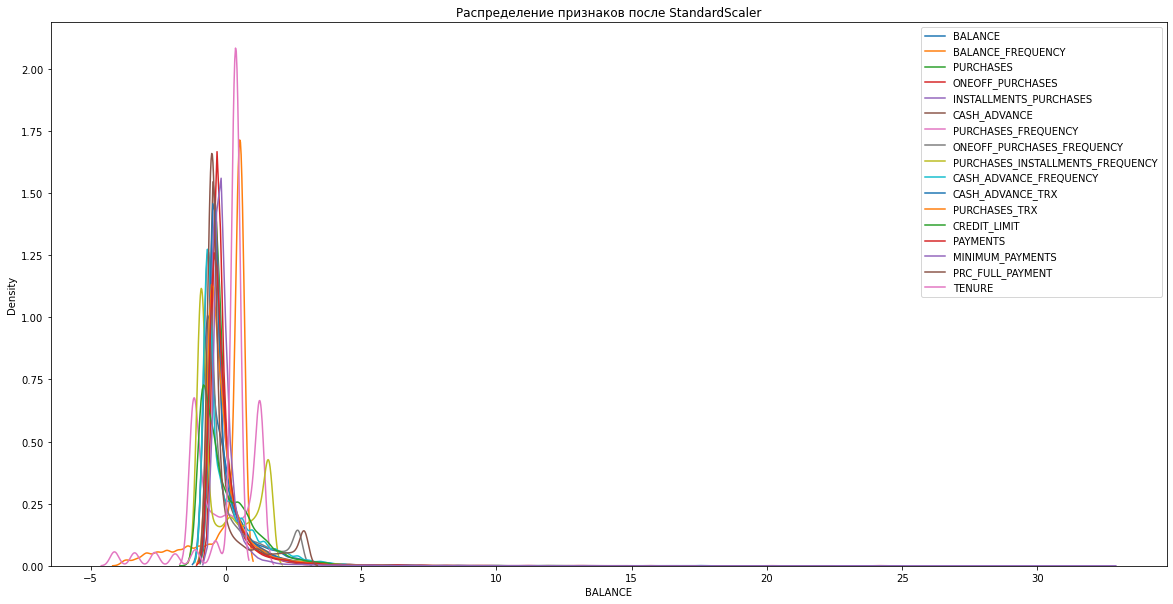

In [32]:
# Задаём параметры графика
fig, (ax) = plt.subplots(
    ncols = 1,               # количество графиков
    figsize = (20, 10)       # размеры шрафика
)

ax.set_title('Распределение признаков после StandardScaler') # наименование графика



# Строим график
for column in cc_general_df_ss.columns:
    sns.kdeplot(cc_general_df_ss[column], ax = ax, label = column)
    
# Выводим график
plt.legend()

## <center> **`5.` Построение и сравнение моделей (Machine Learning)**

#### $5.1$

Начнём с метода — *k-means*. Для начала необходимо узнать число кластеров. Для этого применим коэффициент силуэта, с помощью которого найдём оптимальное количество кластеров, перебрав диапазон от 2 до 9 включительно. 

In [ ]:
# Зафиксируем random_state
random_state = 42

c:\Users\ilyaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ilyaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ilyaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ilyaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ilyaz\anaconda3\lib\site-packages\sklearn\clust

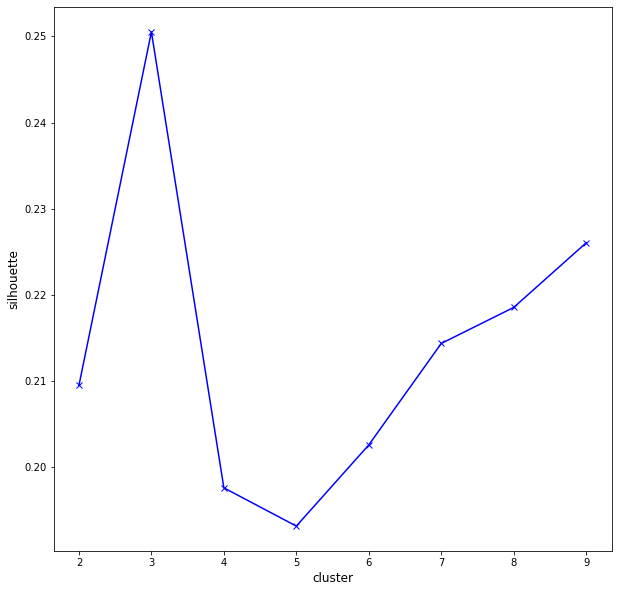

In [34]:
# Создаём функцию для нахождения оптимального количества кластеров
def get_silhouette(cluster_num, X):
    
    # Создаём объект класса KMeans
    model = cluster.KMeans(
        n_clusters = cluster_num,
        random_state = random_state
    )
    
    # Обучаем модель
    model.fit(X)
    
    # Считаем силуэт
    silhouette = metrics.silhouette_score(X, model.labels_, metric = 'euclidean')
    
    return silhouette



# Создаём пустой список, в который будем заносить значения количества кластеров
silhouettes = []

# Пройдёмся циклом по диапазону значений для поиска оптимального
for i in range(2, 10):
    silhouettes.append(get_silhouette(i, cc_general_df_ss))
    
# Визуализируем полученный силуэт
plt.rcParams['figure.figsize'] = (10, 10)
plt.xlabel('cluster', fontsize = 12)
plt.ylabel('silhouette', fontsize = 12)
plt.plot([i for i in range(2, 10)], silhouettes, 'xb-')

#### $5.2$

Теперь реализуем непосредственно кластеризацию *k-means* с оптимальным количеством кластеров, которое мы определили.

In [14]:
# Создаём объект класса KMeans
KM_model = cluster.KMeans(
    n_clusters = 3,
    random_state = random_state
)

# Обучаем модель
KM_model.fit(cc_general_df_ss)

c:\Users\ilyaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [15]:
# Выведем группы, а также количества входящих в них людей
cc_general_df.loc[:, 'label'] = KM_model.labels_
print(f'Группы, а также количества входящих в них людей: \n\n{cc_general_df.label.value_counts()}')

Группы, а также количества входящих в них людей: 

0    6118
1    1597
2    1235
Name: label, dtype: int64


#### $5.3$

Попробуем применить *DBSCAN*. Для начала реализуем его с параметрами по умолчанию.

In [16]:
# Создаём объект класса DBSCAN
DB_model = cluster.DBSCAN()

# Обучаем модель
DB_model.fit(cc_general_df_ss)

DBSCAN()

In [17]:
# Подсчитаем выделенное количество кластеров
clusters = DB_model.labels_
print(f'Полученное количество кластеров: {len(set(clusters)) - (1 if -1 in clusters else 0)}')

Полученное количество кластеров: 38


#### $5.4$

Попробуем с помощью цикла перебрать параметр `eps` по значениям, заданным как `np.arange(0.1,3,0.2)`, а параметр `min_samples` — по значениям, заданным как `range(1,20,4)`. Таким образом попытаемся найти комбинацию, которая даёт максимальное значение коэффициента силуэта.

In [28]:
# Создаём пустой список, в который будем заносить значения количества кластеров
silhouette_list_dbscan = []



# Запускаем цикл перебора параметров eps
for eps in np.arange(0.1, 3, 0.2):
    
    # Запускаем цикл перебора параметров min_samples
    for min_sample in range(1, 20, 4):
        
        # Создаём объект класса DBSCAN
        DB_model = cluster.DBSCAN(
            eps = eps,
            min_samples = min_sample
        )
        
        # Обучаем модель
        DB_model.fit(cc_general_df_ss)
        
        # Считаем силуэт
        silhouette_score = metrics.silhouette_score(cc_general_df_ss, DB_model.labels_, metric = 'euclidean')
        
        # Заносим полученные значения в список
        silhouette_list_dbscan.append((eps, min_sample, silhouette_score, len(set(DB_model.labels_))))
        
        
# Выведем комбинацию, которая даёт максимальное значение коэффициента силуэта        
DBSCAN_df = pd.DataFrame(silhouette_list_dbscan, columns = ['eps', 'min_samples', 'silhouette_score', 'number_of_clusters'])
DBSCAN_df.sort_values(ascending = False, by = 'silhouette_score').head(1)

,eps,min_samples,silhouette_score,number_of_clusters
71,2.9,5,0.617345,2


#### $5.5$

Теперь реализуем агломеративную иерархическую кластеризацию. Переберём количество кластеров в диапазоне от 3 до 9 включительно и найдём то их число, которое будет давать максимальный коэффициент силуэта.

In [23]:
# Создаём пустой список, в который будем заносить значения количества кластеров
silhouette_list_hierarchical = []



# Запускаем цикл перебора параметров
for clusters in range(3, 10, 1):
    
    # Создаём объект класса AgglomerativeClustering
    # и обучаем модель
    AC_model = cluster.AgglomerativeClustering(
        affinity = 'euclidean',
        n_clusters = clusters
    ).fit_predict(cc_general_df_ss)
    
    # Считаем силуэт
    silhouette_score = metrics.silhouette_score(cc_general_df_ss, AC_model, metric = 'euclidean')
    
    # Заносим полученные значения в список
    silhouette_list_hierarchical.append((clusters, silhouette_score, len(set(AC_model))))
    


# Выведем комбинацию, которая даёт максимальное значение коэффициента силуэта 
HIERARCHICAL_df = pd.DataFrame(silhouette_list_hierarchical, columns = ['cluster', 'silhouette_score', 'number_of_clusters'])
HIERARCHICAL_df.sort_values(ascending = False, by = 'silhouette_score').head(1)

c:\Users\ilyaz\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\ilyaz\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\ilyaz\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\ilyaz\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\ilyaz\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 

,cluster,silhouette_score,number_of_clusters
3,6,0.173356,6


#### $5.6$

Обучим на наших данных модель агломеративной иерархической кластеризации с полученным количеством кластеров.

In [24]:
# Создаём объект класса AgglomerativeClustering
AC_model = cluster.AgglomerativeClustering(
    affinity = 'euclidean',
    n_clusters = 6
)

# Обучаем модель
AC_model.fit(cc_general_df_ss)

c:\Users\ilyaz\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', n_clusters=6)

Выведем количество наблюдений.

In [25]:
cc_general_df['cluster_id'] = AC_model.labels_
print('Все наблюдения: \n\n{}'.format(cc_general_df['cluster_id'].value_counts()))

Все наблюдения: 

0    3946
1    2931
2     864
5     722
3     464
4      23
Name: cluster_id, dtype: int64


#### $5.7$

Давайте визуализируем результаты кластеризации *k-means*, отобразив два признака — количество покупок и кредитный лимит:

c:\Users\ilyaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


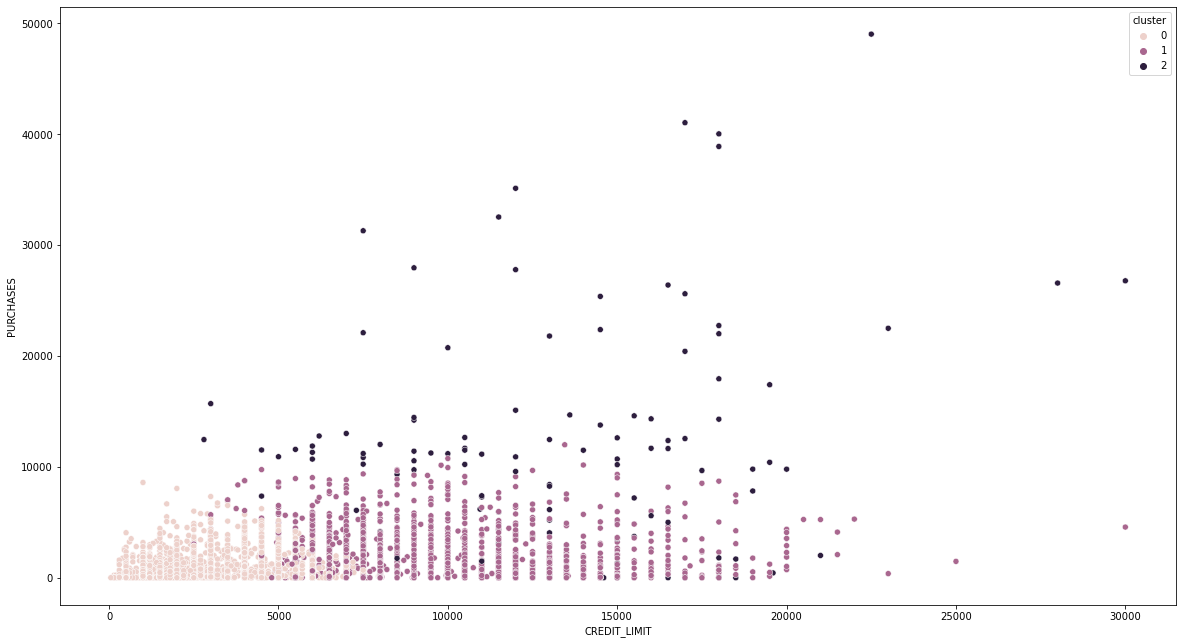

In [27]:
# Создаём объект класса KMeans
KM_model = cluster.KMeans(
    n_clusters = 3, 
    random_state = random_state
)

# Обучаем модель
KM_model.fit(cc_general_df)

# Создаём столбец кластеров
cc_general_df['cluster'] = KM_model.labels_

# Строим график
plt.figure(figsize = (20, 11))

sns.scatterplot(
    data = cc_general_df,
    x = 'CREDIT_LIMIT',
    y = 'PURCHASES',
    hue = 'cluster'
)

# Выводим график
plt.show()

**Вывод:**

Мы видим, что практически все точки очень плотно сконцентрированы вместе, так что наши результаты с другими алгоритмами вполне предсказуемы.

С точки зрения интерпретации на графике явно выделяется группа тех, кто совершает много покупок по кредитной карте, и тех, кто совершает их меньше и имеет меньший кредитный лимит.